1.6.04.28

# 1. Introduction 

A brief description of your approach to the problem and the results that you have obtained on the training data.

<font color="red"><b>!!!!!!!! FILL THIS IN PLS<b>

# 2. Data Import

This section is how you import the data into the notebook. It should be written in such a way that I can modify it to run on my own machine by simply changing the location of the training data and any additional data sources that you have used.


### 2.1 Import the libraries

In [212]:
# The dependencies for anaconda can be downloaded from the main directory.
# There are some version control works have to be done for the incompatibility
# e.g. 'pandas_ml does not work with pandas >= 0.25.0, so we used the pandas = 0.24.2'
import numpy as np
import pandas as pd
import pandas_profiling
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
# from pandas_ml import ConfusionMatrix

from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import fbeta_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)
%matplotlib inline

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN

from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB

### 2.2 Load the datasets

In [213]:
df_train = pd.read_csv("DataFiles/CreditCard_train.csv",header = 1)
df_test = pd.read_csv("DataFiles/CreditCard_test.csv",header = 1)

In [214]:
all_data = pd.concat([df_train,df_test])
all_data.reset_index(inplace = True)
# all_data.set_index('ID')
# all_data.index = range(len(all_data.index))

In [215]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 26 columns):
index                         30000 non-null int64
ID                            30000 non-null int64
LIMIT_BAL                     30000 non-null int64
SEX                           30000 non-null int64
EDUCATION                     30000 non-null int64
MARRIAGE                      30000 non-null int64
AGE                           30000 non-null int64
PAY_0                         30000 non-null int64
PAY_2                         30000 non-null int64
PAY_3                         30000 non-null int64
PAY_4                         30000 non-null int64
PAY_5                         30000 non-null int64
PAY_6                         30000 non-null int64
BILL_AMT1                     30000 non-null int64
BILL_AMT2                     30000 non-null int64
BILL_AMT3                     30000 non-null int64
BILL_AMT4                     30000 non-null int64
BILL_AMT5               

### 2.3 Data dictionary
Below is a data dictionary from https://www.kaggle.com/yapsoonchung/eda-on-default-of-credit-card-clients-dataset/comments & https://www.researchgate.net/publication/326171439_Default_Payment_Analysis_of_Credit_Card_Clients

# 3. Data Transformation & EDA
any exploration of the data that you performed such as visualization, feature extraction, etc.

### 3.1 Data Transformation

In [216]:
# check for unique values in each columns
for c in all_data.columns[2:11]:
    unique_vals = all_data[c].unique()
    print(c,"-"*5,unique_vals)

LIMIT_BAL ----- [  20000  120000   90000   50000  500000  100000  140000  200000  260000
  630000   70000  250000  320000  360000  180000  130000  450000   60000
  230000  160000  280000   10000   40000  210000  150000  380000  310000
  400000   80000  290000  340000  300000   30000  240000  470000  480000
  350000  330000  110000  420000  170000  370000  270000  220000  190000
  510000  460000  440000  410000  490000  390000  580000  600000  620000
  610000  700000  670000  680000  430000  550000  540000 1000000  530000
  710000  560000  520000  750000  640000   16000  570000  590000  660000
  720000  327680  740000  800000  760000  690000  650000  780000  730000]
SEX ----- [2 1]
EDUCATION ----- [2 1 3 5 4 6 0]
MARRIAGE ----- [1 2 3 0]
AGE ----- [24 26 34 37 57 29 23 28 35 51 41 30 49 39 40 27 47 33 32 54 58 22 25 31
 46 42 43 45 56 44 53 38 63 36 52 48 55 60 50 75 61 73 59 21 67 66 62 70
 72 64 65 71 69 68 79 74]
PAY_0 ----- [ 2 -1  0 -2  1  3  4  8  7  5  6]
PAY_2 ----- [ 2  0 -1 -2

Issues found:
1. SEX: The encoding should be changed to 0(female) and 1(male)
2. EDUCATION: Merge the label [0,5,6] with 4(others)
3. MARRIAGE: Merge the label [0] with 3(others)
4. PAY_0: Rename to PAY_1

In [217]:
def transform(data):
    
    #rename the feature PAY_0 to keep the names consistent
    data = data.rename(columns={"PAY_0": "PAY_1"}) 
    
    #0:female,1:male
    sex = {2:0} 
    data["SEX"] = data["SEX"].replace(sex)
    
    #recatergorize unknown labels
    data["EDUCATION"].replace([0,5,6], 4, inplace = True)
    data["MARRIAGE"].replace([0], 3, inplace = True)
    
    #drop ID, as this information does not help predicting the default value
    data.drop('ID', axis = 1,inplace = True)
    data.drop('index', axis = 1,inplace = True)
    
    return data

In [218]:
all_data = transform(all_data)

### 3.2 Data Exploration (EDA)

1. Use auto-generated report to get an overview of the data
2. Use boxplots to visualize outliners in numerial features
3. Use describe() to retrive the gereral statistics for each feature
4. Use countplot() to visualise the distribution of all the categorical features
5. Explore sum of pay status
6. Explore limit - bill
7. Explore Bill - Paid
8. Evaluate the skewness of the distribution

#### 3.2.1 Auto-generated report

In [219]:
# check data types, features, null values
pandas_profiling.ProfileReport(all_data)

Number of variables,24
Number of observations,30000
Total Missing (%),0.0%
Total size in memory,5.5 MiB
Average record size in memory,192.0 B
Numeric,17
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,5


#### 3.2.2 use boxplots to evaluate the skewness of and visualize outliners

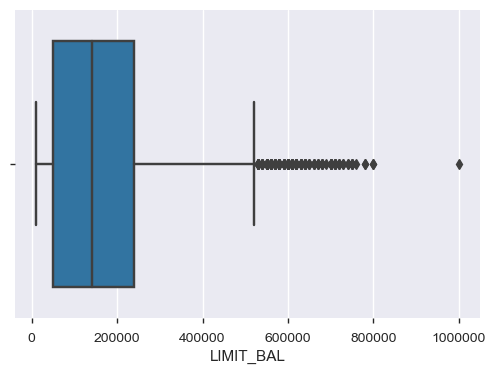

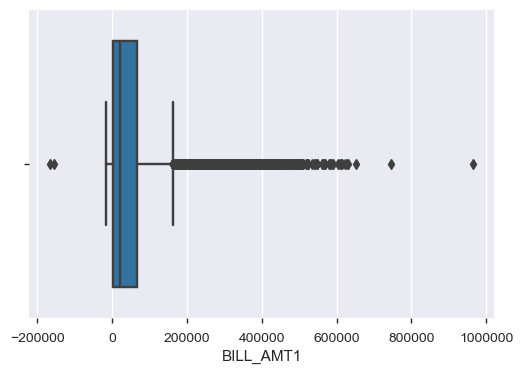

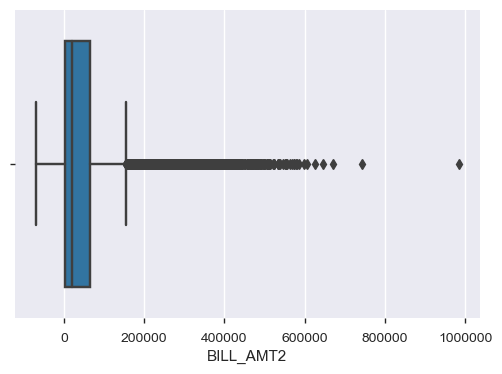

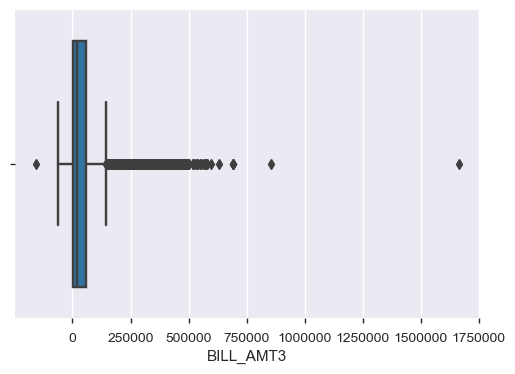

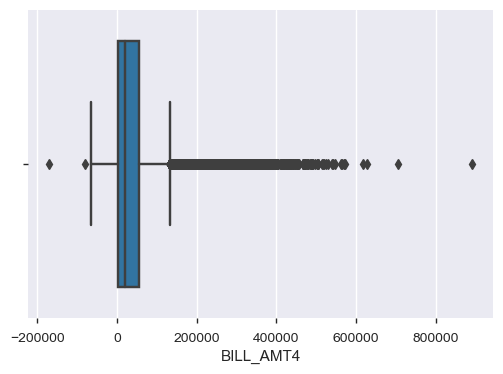

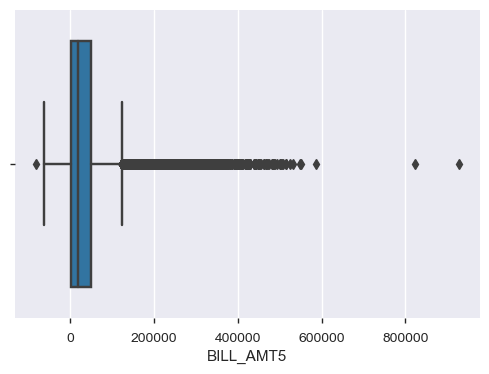

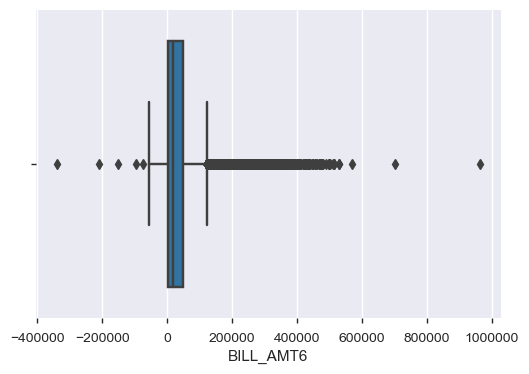

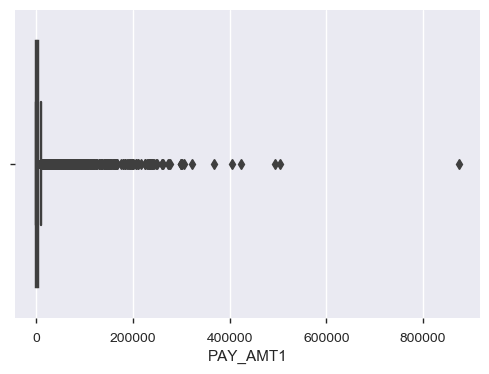

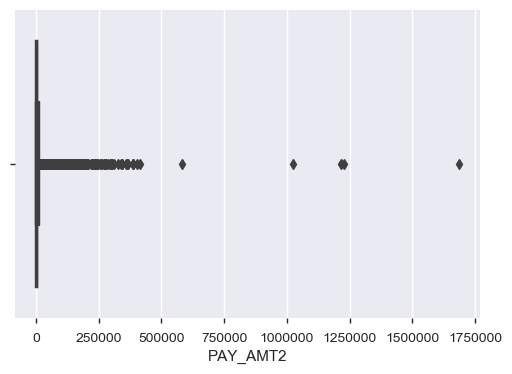

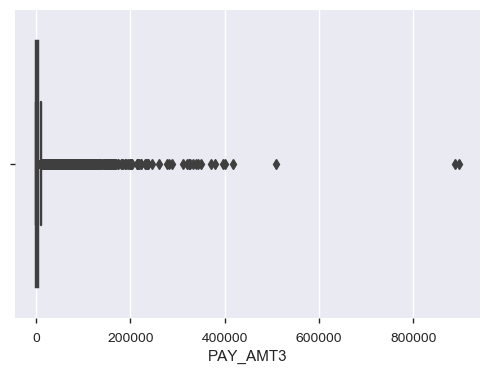

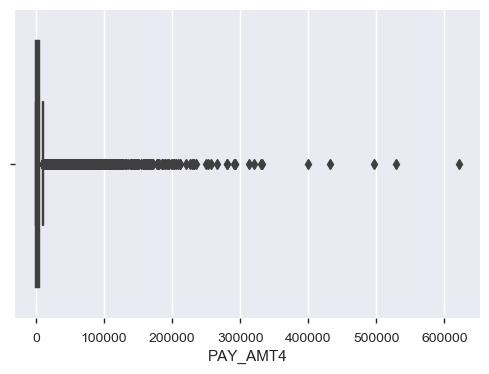

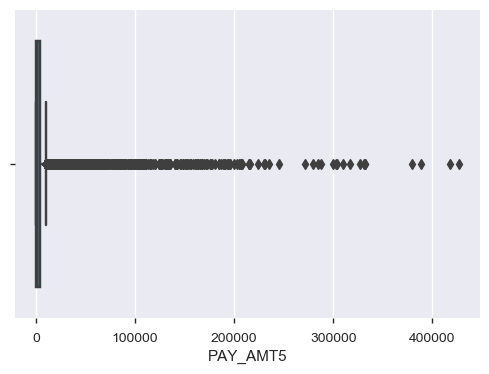

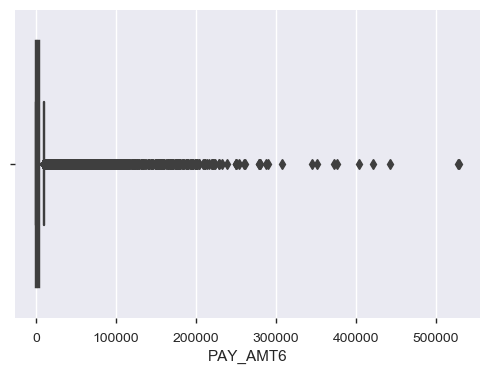

In [220]:
for c in ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    fig, ax = plt.subplots(figsize=(6,4))
    sns.boxplot(x=all_data[c])
    plt.show()

#### 3.2.3 Use describe( ) to retrive the gereral statistics for each feature

In [221]:
all_data.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,0.396267,1.842267,1.557267,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.744494,0.521405,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,0.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,0.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,1.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,1.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [222]:
#we divided the statistics into 4 catergories incase we need to use these statistics later in feature engineering
general_stats= all_data.describe().iloc[:,:5]
pay_status_stats = all_data.describe().iloc[:,5:11]
bill_stats = all_data.describe().iloc[:,11:17]
payed_stats = all_data.describe().iloc[:,17:23]

# save the Q1 and Q3 in separate dataframe
Q1 = pd.concat([general_stats.loc["25%"],bill_stats.loc["25%"],payed_stats.loc["25%"]])
Q3 = pd.concat([general_stats.loc["75%"],bill_stats.loc["75%"],payed_stats.loc["75%"]])

In [366]:
# all_data.iplot()

#### 3.2.4 use countplot( ) to visualise the distribution of all the categorical features and the distribution of "default of next month"

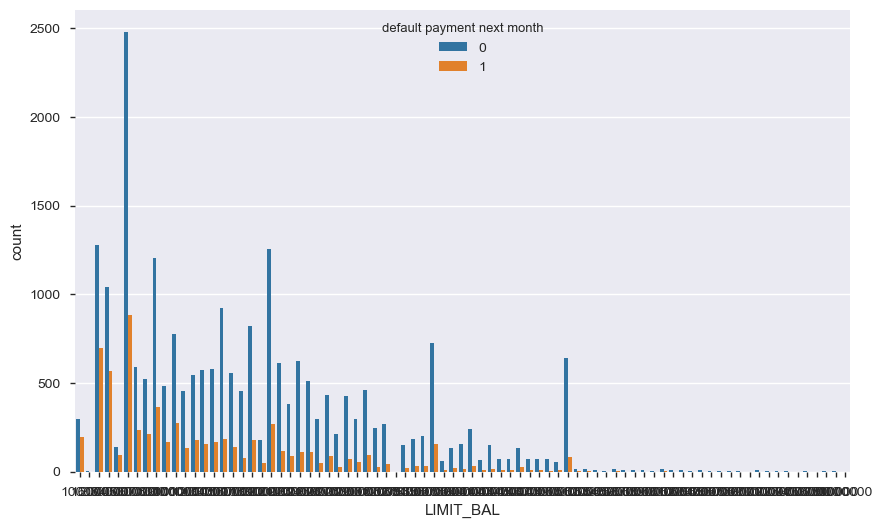

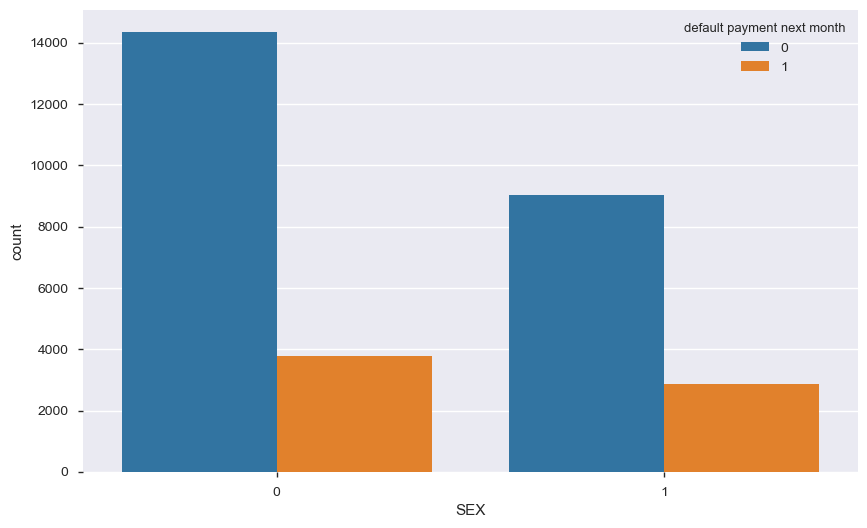

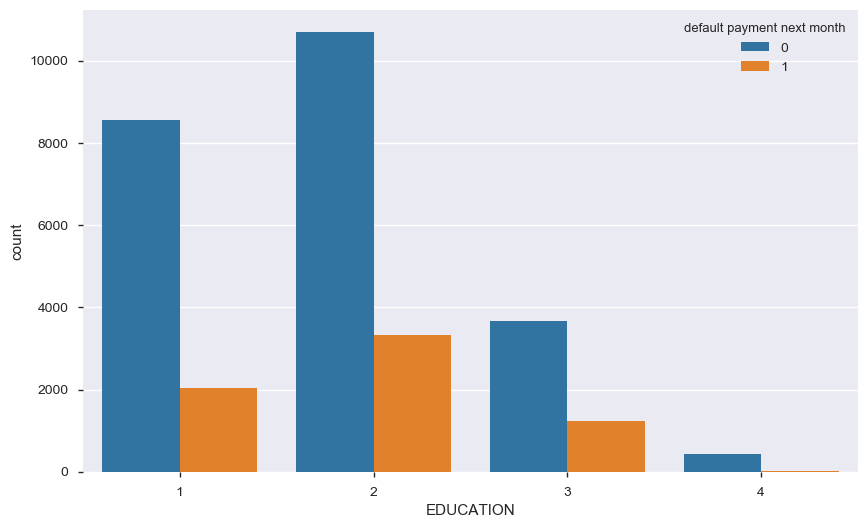

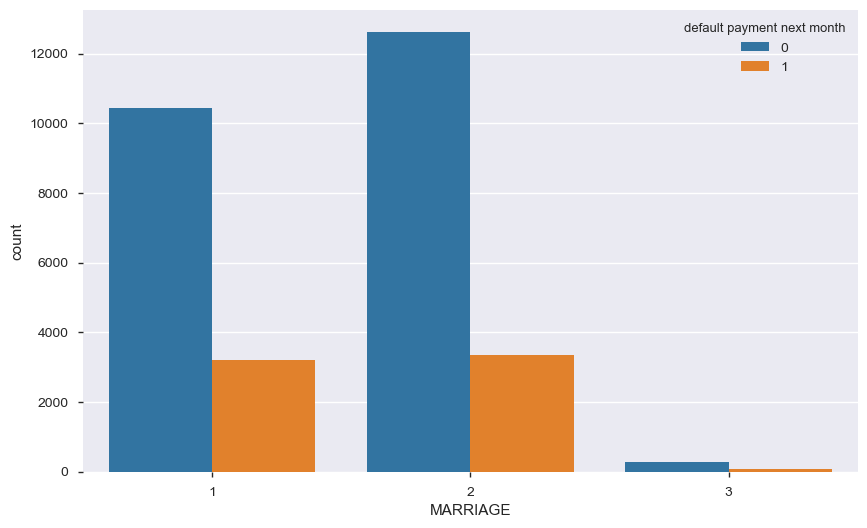

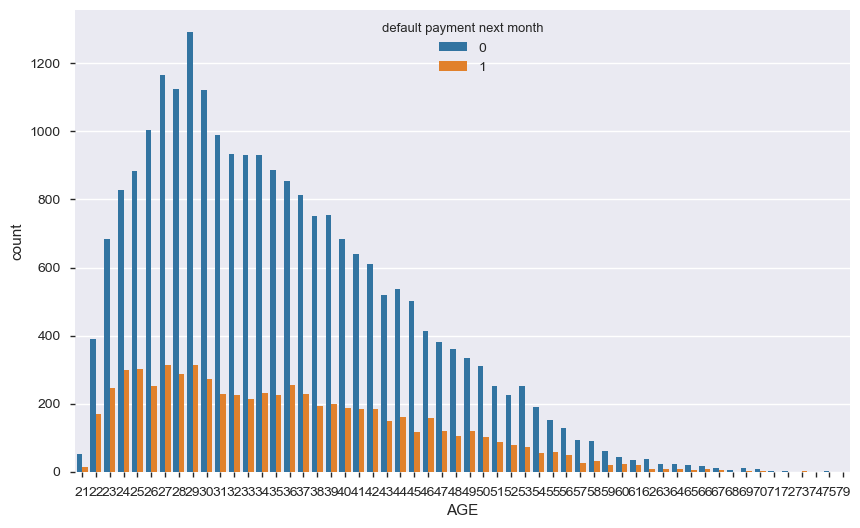

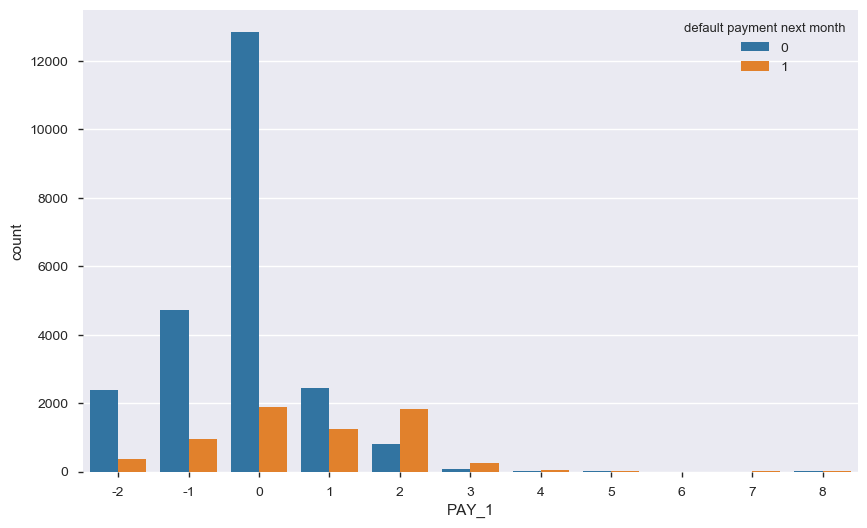

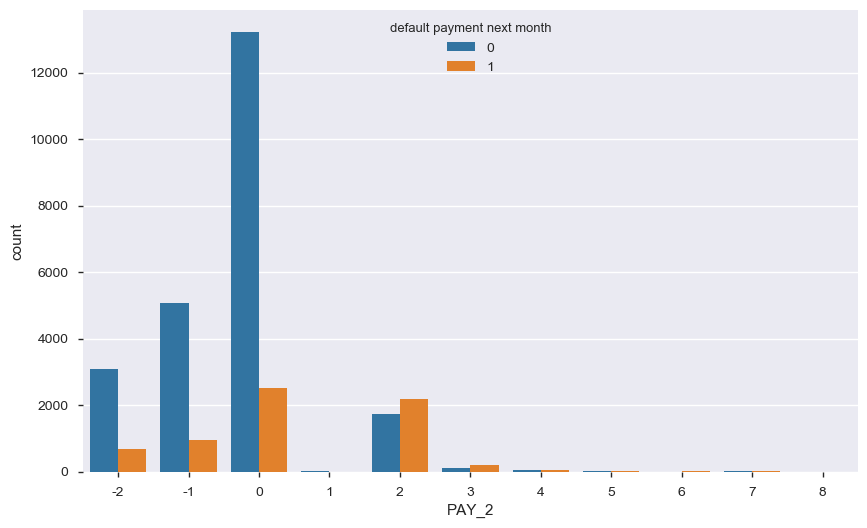

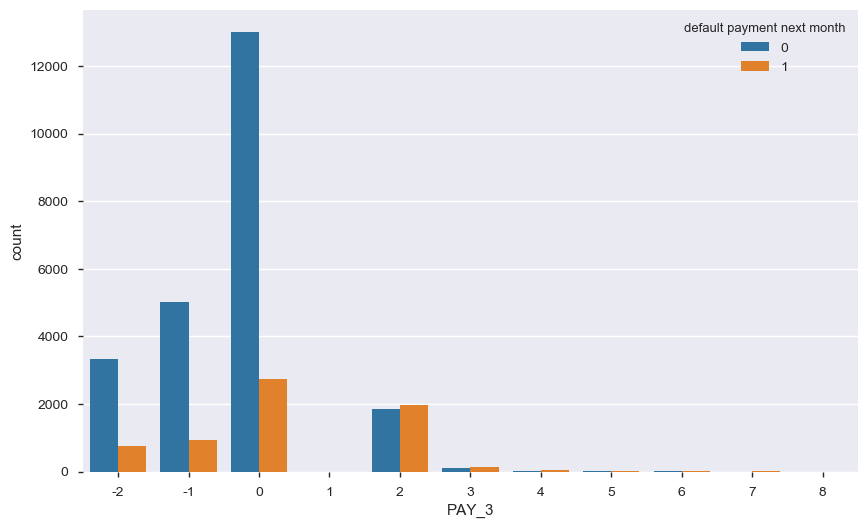

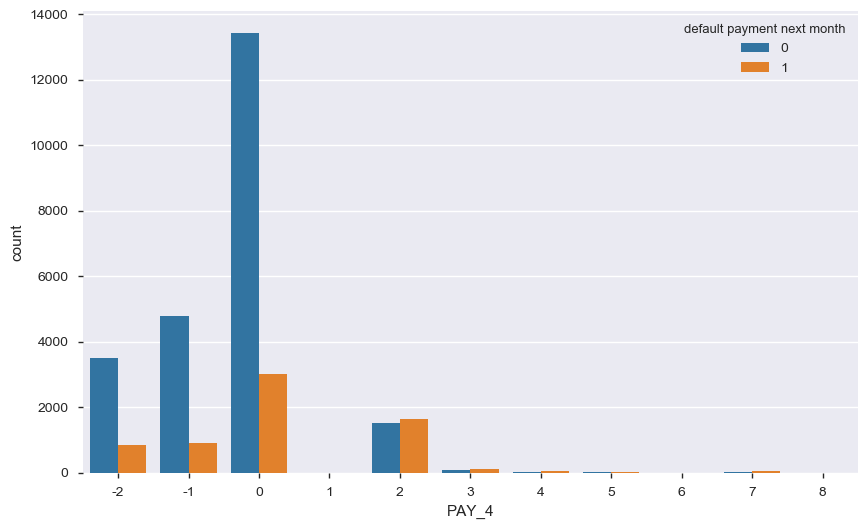

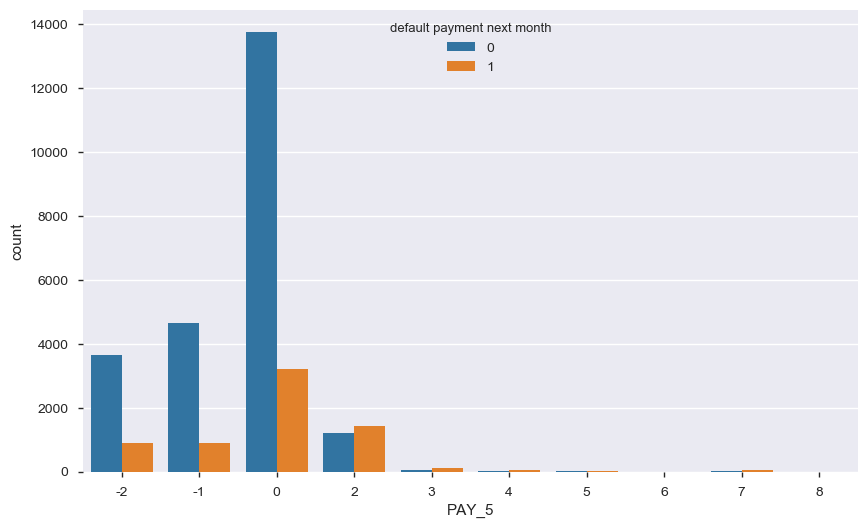

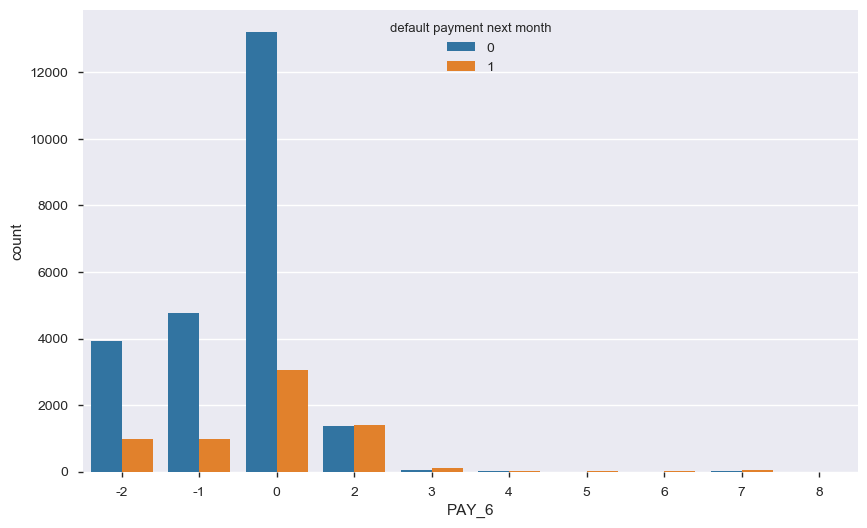

In [223]:
for c in all_data.columns[:11]:
    fig, ax = plt.subplots(figsize=(10,6))
    sns.countplot(x = c, hue="default payment next month", data = all_data)

#### 3.2.5 Explore sum of pay status

Because the the encoding for payment status ranged from -2 to infinitive, and the less is the better. We can add up all the payment status and use the sum to plot a graph. We can divide the data into two groups which are "ltz": less than zero and "mtz":more than zero, and investigate the percentage of getting default next month in each group.

In [228]:
pay_status_sum = all_data.iloc[:, 5:11].sum(axis=1)
bill_sum = all_data.iloc[:, 11:17].sum(axis=1)
pay_sum = all_data.iloc[:, 17:23].sum(axis=1)

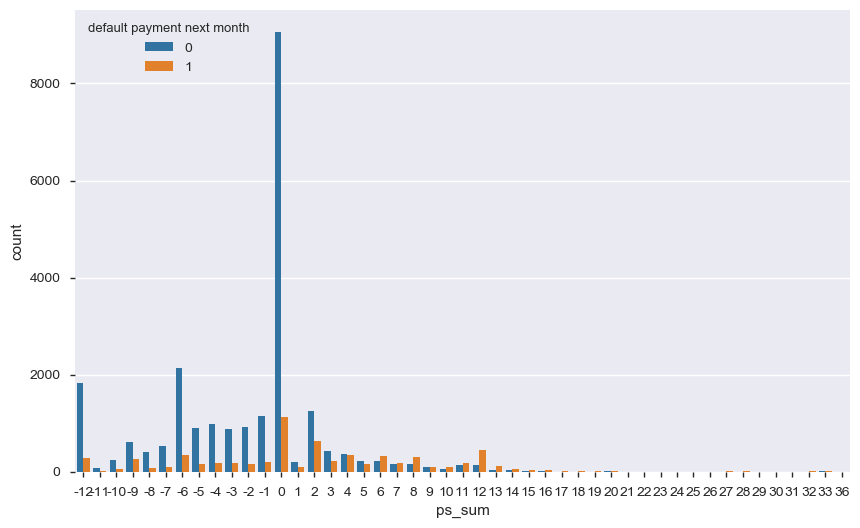

In [229]:
all_data["ps_sum"]  = pay_status_sum
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x = "ps_sum", hue="default payment next month", data = all_data)

In [230]:
ltz = all_data[all_data["ps_sum"]<=0]
mtz = all_data[all_data["ps_sum"]>0]
ltz_1 = ltz["default payment next month"][ltz["default payment next month"]==1].count()/len(ltz)
mtz_1 = mtz["default payment next month"][mtz["default payment next month"]==1].count()/len(mtz)

print("Percentage of individuals getting default with a sum of pay status <=0: {:.3f}%".format(ltz_1*100))
print("Percentage of individuals getting default with a sum of pay status >0: {:.3f}%".format(mtz_1*100))

Percentage of individuals getting default with a sum of pay status <=0: 13.815%
Percentage of individuals getting default with a sum of pay status >0: 48.745%


#### 3.2.6 Explore limit-bill

In [231]:
all_data["limit-bill"] = all_data['LIMIT_BAL']*6 - bill_sum

In [232]:
spent_less_than_limit = all_data[all_data["limit-bill"]>=0]
spent_more_than_limit= all_data[all_data["limit-bill"]<0]
sll_1 = spent_less_than_limit["default payment next month"][spent_less_than_limit["default payment next month"]==1].count()/len(spent_less_than_limit)
sml_1 = spent_more_than_limit["default payment next month"][spent_more_than_limit["default payment next month"]==1].count()/len(spent_more_than_limit)

print("Percentage of individuals getting default who spent less than the limit: {:.3f}%".format(sll_1*100))
print("Percentage of individuals getting default who spent more than the limit: {:.3f}%".format(sml_1*100))

Percentage of individuals getting default who spent less than the limit: 21.857%
Percentage of individuals getting default who spent more than the limit: 34.223%


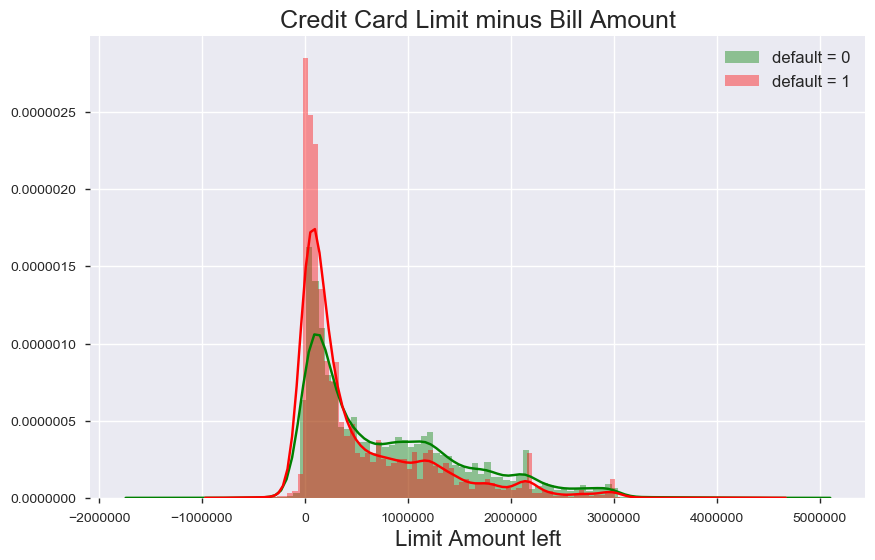

In [233]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(all_data["limit-bill"][all_data["default payment next month"]==0],color='green', bins=100,label = 'default = 0')
sns.distplot(all_data["limit-bill"][all_data["default payment next month"]==1],color='red', bins=100,label = 'default = 1')
plt.title('Credit Card Limit minus Bill Amount', fontsize=18)
plt.xlabel('Limit Amount left', fontsize=16)
plt.legend(prop={'size': 12})

#### 3.2.7 Explore Bill - Pay

In [234]:
# bill_sum.replace(0, 0.001, inplace = True) #so that the denominator won't be zero
all_data["bill-pay"] = bill_sum - pay_sum

In [235]:
paid_less_than_bill = all_data[all_data["bill-pay"]>0]
paid_more_than_bill = all_data[all_data["bill-pay"]<=0]
plb_1 = paid_less_than_bill["default payment next month"][paid_less_than_bill["default payment next month"]==1].count()/len(paid_less_than_bill)
pmb_1 = paid_more_than_bill["default payment next month"][paid_more_than_bill["default payment next month"]==1].count()/len(paid_more_than_bill)

print("Percentage of individuals getting default who paid less than the bill: {:.3f}%".format(plb_1*100))
print("Percentage of individuals getting default who paid more than the bill: {:.3f}%".format(pmb_1*100))

Percentage of individuals getting default who paid less than the bill: 22.472%
Percentage of individuals getting default who paid more than the bill: 20.178%


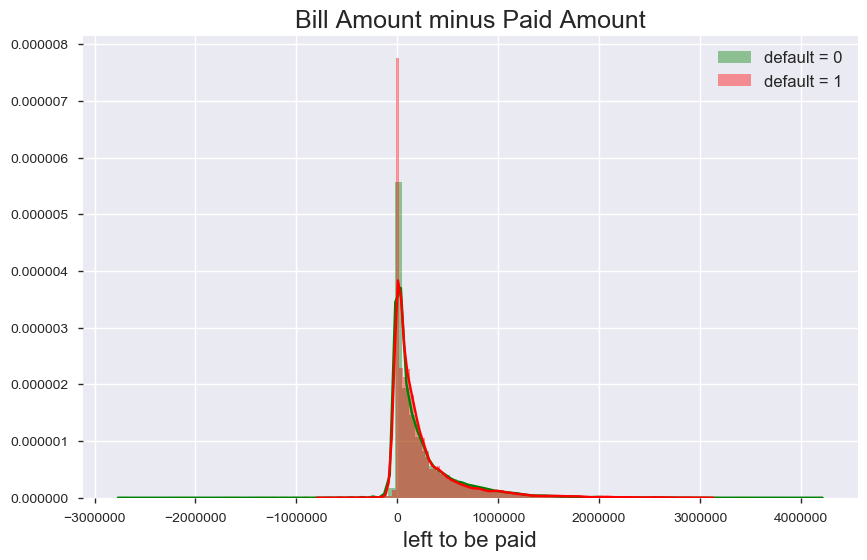

In [236]:
fig, ax = plt.subplots(figsize=(10,6))
sns.distplot(all_data["bill-pay"][all_data["default payment next month"]==0],color='green', bins=100,label = 'default = 0')
sns.distplot(all_data["bill-pay"][all_data["default payment next month"]==1],color='red', bins=100,label = 'default = 1')
plt.title('Bill Amount minus Paid Amount', fontsize=18)
plt.xlabel('left to be paid', fontsize=16)
plt.legend(prop={'size': 12})

In [237]:
# bills = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
#        'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
#        'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
# for c in bills:
#     fig, ax = plt.subplots(figsize=(10,6))
#     plt.title(c + " Distribution", fontsize=12)
#     plt.xlabel('Amount in Dollars', fontsize=10)
#     plt.ylabel('Frequency', fontsize=10)
#     n, bins, patches = plt.hist(x=all_data[c], bins='auto', color='#0504aa', rwidth=0.85)

From the above diagram, we can see that the data is highly skewed, transformation is necessary  before trainning so that the data do not negatively affect the performance of a learning algorithm. Later I will be using a cubic root transformation significantly to reduce the range of values caused by outliers.

### 3.2.8 Summary of EDA

1. Use auto-generated report to get an overview of the data

    1. what problems did we find
        1. From the ProfileReport we can know that this dataset is not balanced. I.e only 20% of the dataset have a default of 1.
        2. The BIll_AMT 2-6 are highly correlated with BILL_AMT1
        3. The PAY_AMT2 is highly skewed
 
    2. what we can do to resolve this 
        1. use resample method to create or reduce the number of data in the engineering step
        2. may remove these columns in the engineering step
        
2. Use boxplots to evaluate skewness and visualize outliners
    1. what problems did we find
        1. All the bill amts and pay amts feature are highly right-skewed.
        2. The range for these values are extremely large, If a feature has a variance that is too big, it may dominate the objective function and make the model unable to learn from other features correctly as expected. 
        
    2. what we can do to resolve this 
        1. use cubic transformation to do normalisation in the engineering step
        2. use minmaxscal() function to scale the range in the engineering step
        
3. Use describe() to retrive the gereral statistics for each feature
    1. Nothing special was found
    
4. Use countplot() to visualise the distribution of all the categorical features
    *********fill this in**********
5. Explore sum of pay status 
    *********fill this in**********
6. Explore limit - bill
    *********fill this in**********
7. Explore Bill - Paid
    *********fill this in**********

5,6,7 are new features we constructed ourself, we added this feature to help the mining process. We are hoping to find a new feature which can be used to separate the default and non-default group Significantly for.

use this source and your own findings to fill this part in 
https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5

# 4. Methodology Overview

1. overview
2. Data Engineering
3. Training and Evaluating Model

#### 4.1 Overview



#### 4.2 Data Engineering

#### 4.2.1 Use the “rule of thumb” to remove outliners

reference: http://myweb.sabanciuniv.edu/rdehkharghani/files/2016/02/The-Morgan-Kaufmann-Series-in-Data-Management-Systems-Jiawei-Han-Micheline-Kamber-Jian-Pei-Data-Mining.-Concepts-and-Techniques-3rd-Edition-Morgan-Kaufmann-2011.pdf

In [238]:
#new Q1 = Q1 - 1.5*IQR
#new Q3 = Q3 + 1.5*IQR
quertiles = pd.DataFrame(Q1)
quertiles["Q3"] = Q3
quertiles.columns = ["Q1","Q3"]
quertiles["IQR"] = quertiles["Q3"] - quertiles["Q1"]
quertiles["newQ1"] = quertiles["Q1"] -1.5*quertiles["IQR"]
quertiles["newQ3"] = quertiles["Q3"] +1.5*quertiles["IQR"]
quertiles

,Q1,Q3,IQR,newQ1,newQ3
LIMIT_BAL,50000.00,240000.00,190000.00,-235000.000,525000.000
SEX,0.00,1.00,1.00,-1.500,2.500
EDUCATION,1.00,2.00,1.00,-0.500,3.500
MARRIAGE,1.00,2.00,1.00,-0.500,3.500
AGE,28.00,41.00,13.00,8.500,60.500
BILL_AMT1,3558.75,67091.00,63532.25,-91739.625,162389.375
BILL_AMT2,2984.75,64006.25,61021.50,-88547.500,155538.500
BILL_AMT3,2666.25,60164.75,57498.50,-83581.500,146412.500
BILL_AMT4,2326.75,54506.00,52179.25,-75942.125,132774.875
BILL_AMT5,1763.00,50190.50,48427.50,-70878.250,122831.750


In [379]:
# remove outliners in LIMIT_BAL

all_data['LIMIT_BAL'][all_data['LIMIT_BAL']>750000] = np.nan

# remove outliners in BILL AMTs
for c in ['BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']:
    all_data[c][all_data[c] < quertiles.loc[c]["newQ1"]] = np.nan
    all_data[c][all_data[c]>(quertiles.loc[c]["newQ3"] +220000)] = np.nan

# remove outliners in PAY AMTs
for c in ['PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    all_data[c][all_data[c]>(quertiles.loc[c]["newQ3"] +200000)] = np.nan

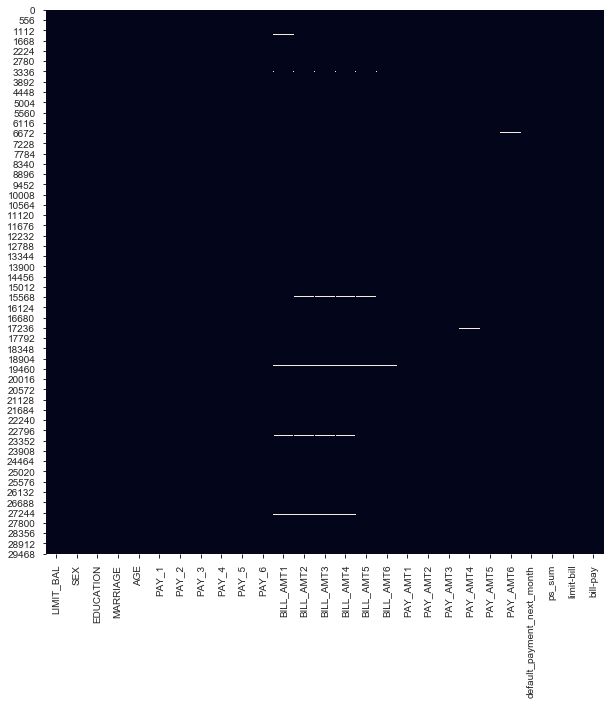

In [380]:
# Investigate patterns in the amount of missing data in each column.
plt.subplots(figsize=(10,10))
sns.heatmap(all_data.isnull(), cbar=False)

In [240]:
# only use the rows with no null values
all_zero_nan = all_data[all_data.isnull().sum(axis=1) == 0]

#### 4.2.2 Binning the AGE features (Discretization)

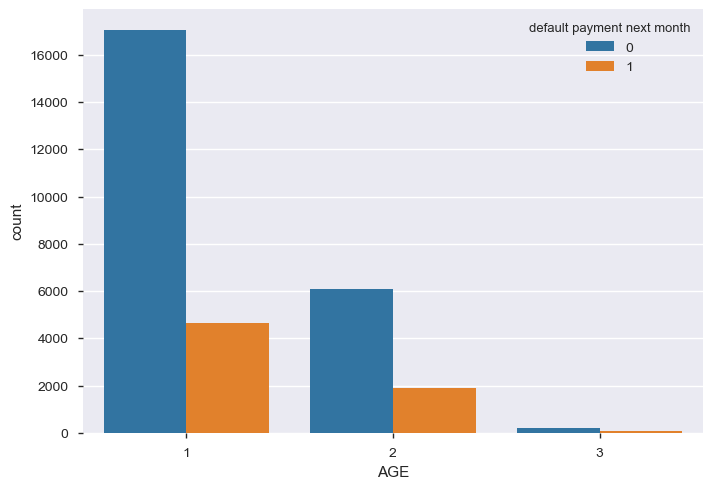

In [241]:
# binning the AGE feature which ranges from 21 to 79
bins = [20,40,60,80]
labels = [1,2,3]
all_zero_nan['AGE'] = pd.cut(all_zero_nan['AGE'], bins, labels=labels)

sns.countplot(x = 'AGE', hue="default payment next month", data = all_zero_nan)

#### 4.2.3 Normalisation and Scaling

In [242]:
# create an engineering function to do normalisation and scaling
def engineer(data):
    
    train = data
    
    #Normalise the range
    bills = ['LIMIT_BAL','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    features_cubic_transformed = train
    features_cubic_transformed[bills] = train[bills].apply(lambda x: np.sign(x) * np.power(abs(x), 1./3))

    ##display normalised data
#     for c in bills:
#         fig, ax = plt.subplots(figsize=(10,6))
#         plt.title("Nomalised " + c)
#         n, bins, patches = plt.hist(x=features_cubic_transformed[c], bins='auto', color='#0504aa')
    
    # scale all numerical data
    numerical = ['LIMIT_BAL','PAY_1',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    
    scaler = MinMaxScaler()
    features_cubic_transformed[numerical] = scaler.fit_transform(features_cubic_transformed[numerical])
    

    final = pd.get_dummies(features_cubic_transformed, columns = ["EDUCATION","MARRIAGE","AGE"])
    
    return final

In [243]:
# clean the data
engineered_data = engineer(all_zero_nan)

In [244]:
# pandas_profiling.ProfileReport(engineered_data)

#### 4.2.4 split train and test data

In [245]:
#save the label to anotehr dataframe
Y = engineered_data['default payment next month']
X = engineered_data
X.drop('default payment next month', axis = 1,inplace = True)

In [320]:
# Split the 'features' and 'income' data into training and testing sets
train_x, test_x, train_y, test_y= train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state = 41)

# Show the results of the split
print("Training set has {} samples.".format(train_x.shape[0]))
print("Testing set has {} samples.".format(test_x.shape[0]))

Training set has 23634 samples.
Testing set has 5909 samples.


In [321]:
# split the original train test data to create a base model
otrain_y = df_train['default payment next month']
otrain_x = df_train
otrain_x.drop('default payment next month', axis = 1,inplace = True)
otrain_x.drop('ID', axis = 1,inplace = True)
otest_y = df_test['default payment next month']
otest_x = df_test
otest_x.drop('default payment next month', axis = 1,inplace = True)
otest_x.drop('ID', axis = 1,inplace = True)

#### 4.2.5 Create a base model

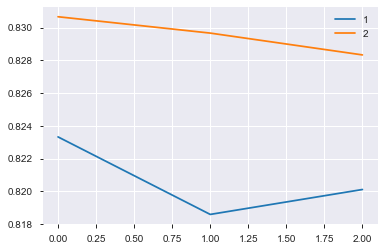

In [322]:
#test accuracy against the original data

first = []
second = []
for n in [1,10,100]:
    #clf1 uses engineered data
    clf1 = AdaBoostClassifier(random_state=41,n_estimators = n)
    clf1.fit(train_x,train_y)
    accuracy1 = clf1.score(test_x,test_y)
    first.append(accuracy1)
    
    #clf2 uses original data
    clf2 = AdaBoostClassifier(random_state=41,n_estimators = n)
    clf2.fit(otrain_x,otrain_y)
    accuracy2 = clf2.score(otest_x,otest_y)
    second.append(accuracy2)

plt.plot(first,label = 1)
plt.plot(second,label = 2)
plt.legend()

#### 4.2.6 visualise feature importance and reduce dimension

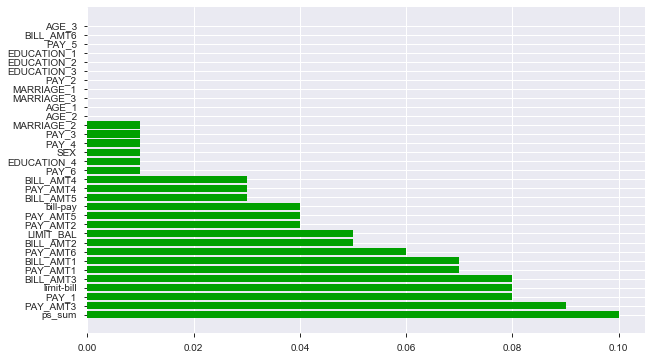

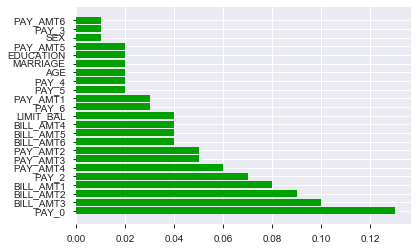

In [323]:
# Compare the importance
i1 = clf1.feature_importances_
i1_df= pd.DataFrame(i1.tolist(), index = train_x.columns)
i1_df.columns = ["clf1"]
i1_df = i1_df.sort_values(by = "clf1",ascending = False)

i2 = clf2.feature_importances_
i2_df= pd.DataFrame(i2.tolist(), index = otrain_x.columns)
i2_df.columns = ["clf2"]
i2_df = i2_df.sort_values(by = "clf2",ascending = False)

fig, ax = plt.subplots(figsize=(10,6))
plt.barh(i1_df.index, i1_df["clf1"],align="center", color = '#00A000',label = "Feature Weight")
# plt.barh(i1_df.index, np.cumsum(i1_df["clf1"]),align = "center", color = '#00A0A0',label = "Cumulative Feature Weight")
plt.show()
plt.barh(i2_df.index, i2_df["clf2"],align="center", color = '#00A000',label = "Feature Weight")
plt.show()

In [324]:
# drop the features which are extremely weak correlated and have very little weight after training
# to_drop = ['SEX', 'EDUCATION', 'MARRIAGE', 'AGE']
# train_x.drop(to_drop, axis = 1,inplace = True)
# test_x.drop(to_drop, axis = 1,inplace = True)

In [325]:
# will be deleted ..

# y = df_train['default payment next month']
# x = df_train.drop('default payment next month', axis = 1,inplace = False)
# x.drop('ID', axis = 1,inplace = True)

# #split the data set into the train and testing sets
# #random_state is the random number generator
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=40)
X_train, X_test, y_train, y_test = train_x, test_x, train_y, test_y

#### 4.2.7 resampling to solve imbalances

resample method

In [394]:
dfForSampling = pd.concat([pd.DataFrame(train_x),pd.DataFrame(train_y)],axis = 1)
df_default = dfForSampling.loc[dfForSampling['default payment next month'] == 1]
df_non_default = dfForSampling.loc[dfForSampling['default payment next month'] == 0]


print("-"*50)
print('The number of people default')
print(df_default['default payment next month'].count())
print("-"*50)
print('The number of people non-default')
print(df_non_default['default payment next month'].count())
print("-"*50)

--------------------------------------------------
The number of people default
5270
--------------------------------------------------
The number of people non-default
18364
--------------------------------------------------


In [395]:
# upscales the default samples to the same size as non default
df_default_upscaled = resample(df_default, replace=True, n_samples=18364, random_state=100)
# Combine the non-default and upscaled default
df_upscaled = pd.concat([df_non_default, df_default_upscaled])

df_upscaled['default payment next month'].value_counts()

1    18364
0    18364
Name: default payment next month, dtype: int64

In [396]:
# downscales the non-default samples to the same size as default
df_non_default_downscaled = resample(df_non_default, replace=True, n_samples=5270, random_state=100)
# Combine the default and downscaled non-default
df_downscaled = pd.concat([df_default, df_non_default_downscaled])

df_downscaled['default payment next month'].value_counts()

1    5270
0    5270
Name: default payment next month, dtype: int64

SMOTE

In [397]:
#SMOTE adopts the 'not. majority' as default sampling strategy, we just rewrite here to annouce that we are only doing
#upscaled but not downscaled so choosing 'not majority' to avoid unbias.
sm = SMOTE(sampling_strategy='not majority',random_state=100)
X_SMOTE, y_SMOTE = sm.fit_sample(train_x, train_y)
print(len(X_SMOTE))
print(y_SMOTE.sum())

36728
18364


ADASYN

In [398]:
ada = ADASYN(random_state=100)
X_ADA, y_ADA = ada.fit_sample(train_x, train_y)
print(len(X_ADA))
print(y_ADA.sum())

36265
17901


# 5. Model Training & Validation
This contains a breakdown of how your model was trained and evaluated.


### 5.1 Using K-fold cross validation to tests the performance of different ensemble classifiers
Here we are using the clean data sets after transformation and feature engineering has been applied, and then feeds into different classifiers to test the performance. We are using runtime, accuracy, fbeta(beta=3) for analysis on the performance.

In [399]:
# set the list of potential classifiers
# clf_list = [
#             #averaging
#             DecisionTreeClassifier(max_depth = 4, min_samples_split = 2,random_state = 100),
#             RandomForestClassifier(n_estimators = 60, random_state = 100),
#             BaggingClassifier(random_state = 100),
#             #boosting
#             AdaBoostClassifier(n_estimators = 60, random_state = 100),
#             GradientBoostingClassifier(),
#             #unknown
#             SGDClassifier(random_state = 100),
#             KNeighborsClassifier(),
#LogisticRegression(random_state=100),
#GaussianNB()
# ]

clf_list = [
            AdaBoostClassifier(n_estimators = 60, random_state = 100),
            LogisticRegression(random_state=100),
            GaussianNB()
]

According to the paper we read, we think it is better to enhance recall since we want more default people can be caught out other than less non-default by wrongly caught out. The reason we used fbeta(beta=3) is that, fbeta(beta=3) considers more recall than precision from the documentation of sklearn.metrics.fbeta_score.

In [400]:
# split the data sets into 6 folders to multple trains and tests
kf = KFold(n_splits=6,random_state=100,shuffle=True)

mdl = []
fold = []
accuracy = []
fbeta = []
timeLength = []

for i,(train_index, test_index) in enumerate(kf.split(dfForSampling)):
    
    training = dfForSampling.iloc[train_index,:]
    test = dfForSampling.iloc[test_index,:]
    print(i)
    for clf in clf_list:
        model = clf.__class__.__name__
        feats = training.drop('default payment next month', axis = 1,inplace = False)
        label = training['default payment next month']
        valid_feats = test.drop('default payment next month', axis = 1,inplace = False)
        valid_label = test['default payment next month']
        start = time()
        clf.fit(feats,label) 
        pred = clf.predict(valid_feats)
        end = time()
        
        accuracyScore = accuracy_score(y_true = valid_label, y_pred = pred)
        fbetaScore= fbeta_score(y_true = valid_label, y_pred = pred, beta = 3)
        
        fold.append(i+1)
        accuracy.append(accuracyScore)
        fbeta.append(fbetaScore)
        timeLength.append(end-start)
        mdl.append(model)
        print(model)


performance = pd.DataFrame({'Model': mdl, 'Accuracy':accuracy, 'Fbeta': fbeta, 'Runtime': timeLength, 'Fold':fold})

0
AdaBoostClassifier
LogisticRegression
GaussianNB
1
AdaBoostClassifier
LogisticRegression
GaussianNB
2
AdaBoostClassifier
LogisticRegression
GaussianNB
3
AdaBoostClassifier
LogisticRegression
GaussianNB
4
AdaBoostClassifier
LogisticRegression
GaussianNB
5
AdaBoostClassifier
LogisticRegression
GaussianNB


In [401]:
# ROC = roc_auc_score(y_true = valid_label, y_scores = pred)

In [402]:
#performance_a[performance_a['Model'] == 'AdaBoostClassifier']['Score'].mean()

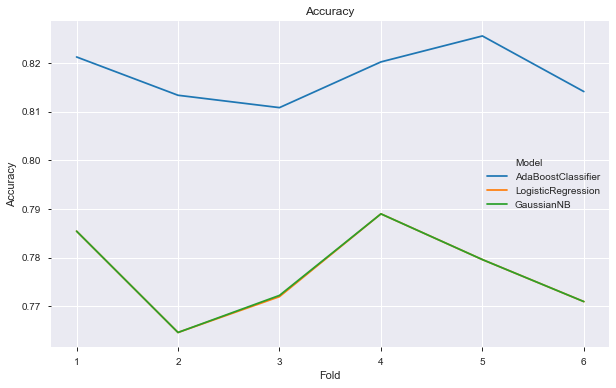

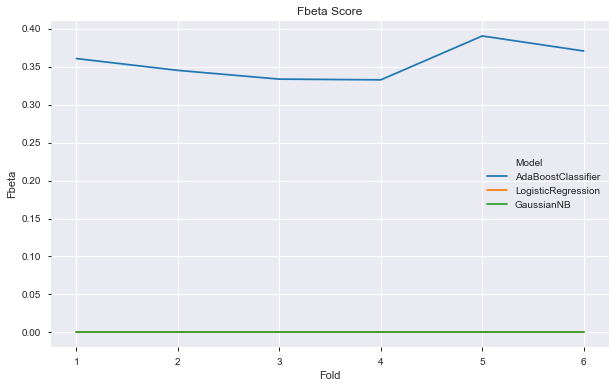

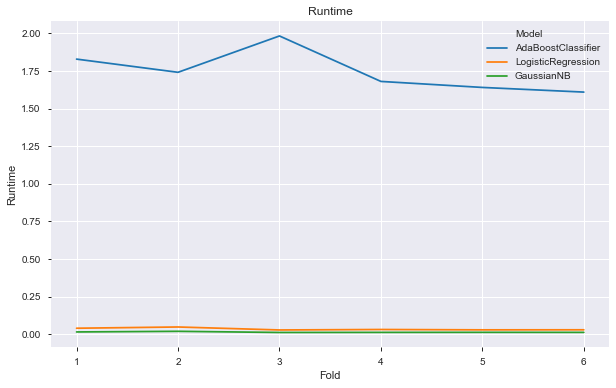

In [403]:
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Accuracy",hue = "Model" ,data=performance).set_title("Accuracy")
plt.show()
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Fbeta",hue = "Model" ,data=performance).set_title("Fbeta Score")
plt.show()
plt.subplots(figsize=(10,6))
sns.lineplot(x="Fold", y="Runtime",hue = "Model" ,data=performance).set_title("Runtime")
plt.show()

In [404]:
# plot the confision matrix and precision_recall_curve
cm = ConfusionMatrix(test_y.tolist(), predictions.tolist())
print("Confusion matrix:\n%s" % cm)
cm.plot()
cm.stats()# to retrieve the dictionary 
print("-"*30)
show_metrics()
score_y = clf.decision_function(test_x)
precision, recall, thresholds = precision_recall_curve(test_y, score_y)
fig, ax = plt.subplots(figsize=(10,6))
plot_precision_recall()

### 5.2 GridSearch CV for tuning

So first of all let's find the best hyperparameters of the classifiers. Due to the limits on the computation, we can only do a little cross-validation which means not very deep and large param_grid but still can make little differences that can prove our guess.

### 5.2.1 AdaBoostClassifier

In [406]:
# define the classifier.
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
# training the classifier
clf.fit(train_x, train_y)
# do our predictions on the test
predictions = clf.predict(test_x)
# see how good it is on default
accuracy_score(y_true = test_y, y_pred = predictions)

0.820104924691149

The score is not too bad as expected, let's how about feed in the best hyperparameters gained by cross-validation in grid(GridSearchCV).

In [425]:
param_grid = {'n_estimators': [1,10,40],
              'algorithm': ['SAMME','SAMME.R'],
              'learning_rate' : [0.01, 0.3, 0.9]}
grid_search_tree = GridSearchCV(AdaBoostClassifier(), param_grid, cv = 5, scoring= 'accuracy')

#training
grid_search_tree.fit(train_x, train_y)
#let's see the best estimator
print(grid_search_tree.best_estimator_)
#with its score
print(np.abs(grid_search_tree.best_score_))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=40, random_state=None)
0.8184819632689673


Let's see the classifier with predicted best hyperparamers gained by cross-validation through GridSearchCV

In [412]:
AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
                   n_estimators=1, random_state=None)
classifier.fit(train_x, train_y)
predictions = classifier.predict(test_x)
accuracy_score(y_true = y_test, y_pred = predictions)

0.822812658656287

There is no big benefits to use oversampling or downsampling here, the reason is that 
+ we will do voting as the last steps to combine all the classifiers we are happy with.
+ due to the limits on the computation, we can only do a little cross-validation as seen above, there is not much differences on hyperparameters.

# 2.RandomForestsClassifier

In [433]:
clf = RandomForestClassifier(n_estimators=100, )
clf.fit(train_x, train_y)
predictions = clf.predict(test_x)
accuracy_score(y_true = y_test, y_pred = predictions)

0.8116432560500931

In [441]:
param_grid = {'n_estimators': [50, 100, 400],
              'criterion': ['entropy', 'gini'],
             }

grid_search_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, scoring= 'accuracy')

#training
grid_search_tree.fit(train_x, train_y)
#let's see the best estimator
print(grid_search_tree.best_estimator_)
#with its score
print(np.abs(grid_search_tree.best_score_))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
0.818143419534336


In [442]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
classifier.fit(train_x, train_y)
predictions = classifier.predict(test_x)
accuracy_score(y_true = y_test, y_pred = predictions)

0.7283804366221018

Even worse, it is better to keep the default. The reason for that is the cross-validation is still to small, it brings underfit to the data, so the clf is unstable and always makes wrong.

In [419]:
# define the clssifier and fit with the train data, predict on the result
classifier = DecisionTreeClassifier(max_depth=500, random_state=42)
classifier.fit(train_x, train_y)
predictions = classifier.predict(test_x)
accuracy_score(y_true = y_test, y_pred = predictions)

0.7283804366221018

In [ ]:
# def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix"', cmap = plt.cm.Blues) :
#     plt.figure()
#     plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation = 0)
#     plt.yticks(tick_marks, classes)
 
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
#         plt.text(j, i, cm[i, j],
#                  horizontalalignment = 'center',
#                  color = 'white' if cm[i, j] > thresh else 'black')
 
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.show()
    
# def show_metrics():
#     tp = cm.stats()['TP']
#     fn = cm.stats()['FN']
#     fp = cm.stats()['FP']
#     tn = cm.stats()['TN']
#     print('Precision: {:.3f}'.format(tp/(tp+fp)))
#     print('Recall: {:.3f}'.format(tp/(tp+fn)))
#     print('F1 score: {:.3f}'.format(2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn))))))

    
# def plot_precision_recall():
#     plt.step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
#     plt.fill_between(recall, precision, step ='post', alpha = 0.2, color = 'b')
#     plt.plot(recall, precision, linewidth=2)
#     plt.xlim([0.0,1])
#     plt.ylim([0.0,1.05])
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision Recall Curve')
#     plt.show();

# plot the confision matrix and precision_recall_curve
# cm = ConfusionMatrix(test_y.tolist(), predictions.tolist())
# print("Confusion matrix:\n%s" % cm)
# cm.plot()
# cm.stats()# to retrieve the dictionary 
# print("-"*30)
# show_metrics()
# score_y = clf.decision_function(test_x)
# precision, recall, thresholds = precision_recall_curve(test_y, score_y)
# fig, ax = plt.subplots(figsize=(10,6))
# plot_precision_recall()

## 5.3 Final Voting on choosen classifiers
The last step is to use the voting algorithm to 

The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

#  6. Results

# 7. Results

Here you show the results that you obtain using your model on the training data. If you have multiple variations or approaches, this is where you compare them.


# 8. Final predictions

This is the section where you perform your final predictions on the test set using the model that you have trained in the previous section.


# 9. References

https://medium.com/analytics-vidhya/what-is-balance-and-imbalance-dataset-89e8d7f46bc5